In [3]:
# Find quotes about difficulty of writing descriptions
# Mention statistics 

%matplotlib inline
import pandas as pd
import re
import codecs

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')

from functools import reduce
# from jupyterthemes import jtplot

# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='chesterish')

def neatify_headers(df):
    old_col_headers = list(df)
    new_col_headers = [och.replace(' ', '') for och in old_col_headers]
    rename_headers_map = {och: nch for och, nch in zip(old_col_headers, new_col_headers)}
    return df.rename(columns=rename_headers_map)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skunche/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/skunche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/skunche/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
# 'preschool_prek', 
filenames = ('k_2', '3_5', '6_8', '9_12')
dfs = []
for grade_category, filename in enumerate(filenames):
    df = pd.read_csv("cal_dept_of_edu/{}.csv".format(filename))
    df = neatify_headers(df)
    df['GradeCategory'] = grade_category
    dfs.append(df)
df = reduce(lambda a, b: a.append(b), dfs)

In [5]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

standardize_text(df, "Annotation")

,TitleID,Title,Annotation,Publisher,Copyright,OriginalCopyright,Translator,Author,Illustrator,GradeLevelSpan,Language,Genre,Classification,Culture,Topic,Discipline,Standard,Award,GradeCategory
0,39313,"""Let's Get a Pup!"" Said Kate",when kate and her parents visit the animal she...,Candlewick Press,2001,NaN,NaN,Bob Graham,Bob Graham,K thru 2,English,Realistic Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/Literary Elements,NaN,NaN,0
1,16516,"""Slowly, Slowly, Slowly,"" Said the Sloth",a day in the life of a sloth is also a message...,Philomel Books,2002,NaN,NaN,Eric Carle,Eric Carle,K thru 2,English,Fiction,Picture Book,NaN,Life Science (Biology),Science,LS K.2,NaN,0
2,37332,'Twas the Night Before Thanksgiving,schoolchildren on a thanksgiving field trip to...,Orchard Books,1991,NaN,NaN,Dav Pilkey,Dav Pilkey,K thru 2,English,Fiction,Picture Book,NaN,English-Language Arts/General,"English-Language Arts/Vocabulary, English-Lang...",NaN,NaN,0
3,38510,"¡Cuidado, pajarito! (Look Out, Bird!)",things in the animal world are never quite the...,Ediciones Norte-Sur,1997,NaN,Alis Alejandro,Marilyn Janovitz,Marilyn Janovitz,K thru 2,Spanish,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
4,38511,¡Hola abuelos! (Hello Grandparents!),this story highlights the special bond shared ...,Buenos Aires: Editorial Planeta Argentina,1999,NaN,NaN,Margarita Maine,Nora Hilb,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",Latino/Latino American,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
5,38512,¡La senorita Nelson ha desaparecido! (Miss Nel...,"when miss nelson's class misbehaves, she disap...",Houghton Mifflin,1998,NaN,Yanitzia Canetti,Harry Allard,James Marshall,"K thru 2, 3 thru 5",Spanish,Fiction,"Picture Book, Read Aloud",NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
6,38513,¡Me gusto como soy! (I Like Me!),she's a pig with confidence and a mind of her ...,Viking Press,1997,NaN,NaN,Nancy Carlson,Nancy Carlson,K thru 2,Spanish,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
7,38514,"¡No, Tito, no! (No, No, Titus!)",when tito moves to the farm with his new famil...,North-South Books,1999,NaN,Diego Lasconi,Claire Masurel,Claire Masurel,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
8,38515,¡Papa! (Father!),"""father!"" they cry out in unison a young boy ...",Barcelona: Editorial Corimbo,1999,NaN,Anna Coll-Vinent,Philippe Corentin,Philippe Corentin,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
9,38516,¡Que monton de tamales! (Too Many Tamales),the importance of honesty is shown as four lat...,Putnam Publishing,1996,NaN,Alma Flor Ada,Gary Soto,Ed Martinez,"K thru 2, 3 thru 5",Spanish,"Fiction, Realistic Fiction","Easy Reader, Picture Book, Read Aloud",Latino/Latino American,English-Language Arts/General,"History/Social Science, English-Language Arts/...","HSS K.3, HSS 1.4",NaN,0


In [6]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["Annotation"].apply(tokenizer.tokenize)
df.head()

,TitleID,Title,Annotation,Publisher,Copyright,OriginalCopyright,Translator,Author,Illustrator,GradeLevelSpan,Language,Genre,Classification,Culture,Topic,Discipline,Standard,Award,GradeCategory,tokens
0,39313,"""Let's Get a Pup!"" Said Kate",when kate and her parents visit the animal she...,Candlewick Press,2001,NaN,NaN,Bob Graham,Bob Graham,K thru 2,English,Realistic Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/Literary Elements,NaN,NaN,0,"[when, kate, and, her, parents, visit, the, an..."
1,16516,"""Slowly, Slowly, Slowly,"" Said the Sloth",a day in the life of a sloth is also a message...,Philomel Books,2002,NaN,NaN,Eric Carle,Eric Carle,K thru 2,English,Fiction,Picture Book,NaN,Life Science (Biology),Science,LS K.2,NaN,0,"[a, day, in, the, life, of, a, sloth, is, also..."
2,37332,'Twas the Night Before Thanksgiving,schoolchildren on a thanksgiving field trip to...,Orchard Books,1991,NaN,NaN,Dav Pilkey,Dav Pilkey,K thru 2,English,Fiction,Picture Book,NaN,English-Language Arts/General,"English-Language Arts/Vocabulary, English-Lang...",NaN,NaN,0,"[schoolchildren, on, a, thanksgiving, field, t..."
3,38510,"¡Cuidado, pajarito! (Look Out, Bird!)",things in the animal world are never quite the...,Ediciones Norte-Sur,1997,NaN,Alis Alejandro,Marilyn Janovitz,Marilyn Janovitz,K thru 2,Spanish,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[things, in, the, animal, world, are, never, q..."
4,38511,¡Hola abuelos! (Hello Grandparents!),this story highlights the special bond shared ...,Buenos Aires: Editorial Planeta Argentina,1999,NaN,NaN,Margarita Maine,Nora Hilb,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",Latino/Latino American,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[this, story, highlights, the, special, bond, ..."


In [7]:
import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html
df['no_punctuation_tokens'] = df['tokens'].apply(lambda tkns: [regex.sub(u'', tkn) for tkn in tkns])

In [8]:
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))
df['no_stop_tokens'] = df['no_punctuation_tokens'].apply(lambda tkns: list(filter(lambda tkn: tkn not in stopword_set, tkns)))
df.head()

,TitleID,Title,Annotation,Publisher,Copyright,OriginalCopyright,Translator,Author,Illustrator,GradeLevelSpan,...,Classification,Culture,Topic,Discipline,Standard,Award,GradeCategory,tokens,no_punctuation_tokens,no_stop_tokens
0,39313,"""Let's Get a Pup!"" Said Kate",when kate and her parents visit the animal she...,Candlewick Press,2001,NaN,NaN,Bob Graham,Bob Graham,K thru 2,...,Picture Book,NaN,English-Language Arts/General,English-Language Arts/Literary Elements,NaN,NaN,0,"[when, kate, and, her, parents, visit, the, an...","[when, kate, and, her, parents, visit, the, an...","[kate, parents, visit, animal, shelter, select..."
1,16516,"""Slowly, Slowly, Slowly,"" Said the Sloth",a day in the life of a sloth is also a message...,Philomel Books,2002,NaN,NaN,Eric Carle,Eric Carle,K thru 2,...,Picture Book,NaN,Life Science (Biology),Science,LS K.2,NaN,0,"[a, day, in, the, life, of, a, sloth, is, also...","[a, day, in, the, life, of, a, sloth, is, also...","[day, life, sloth, also, message, slow, many, ..."
2,37332,'Twas the Night Before Thanksgiving,schoolchildren on a thanksgiving field trip to...,Orchard Books,1991,NaN,NaN,Dav Pilkey,Dav Pilkey,K thru 2,...,Picture Book,NaN,English-Language Arts/General,"English-Language Arts/Vocabulary, English-Lang...",NaN,NaN,0,"[schoolchildren, on, a, thanksgiving, field, t...","[schoolchildren, on, a, thanksgiving, field, t...","[schoolchildren, thanksgiving, field, trip, ma..."
3,38510,"¡Cuidado, pajarito! (Look Out, Bird!)",things in the animal world are never quite the...,Ediciones Norte-Sur,1997,NaN,Alis Alejandro,Marilyn Janovitz,Marilyn Janovitz,K thru 2,...,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[things, in, the, animal, world, are, never, q...","[things, in, the, animal, world, are, never, q...","[things, animal, world, never, quite, snail, s..."
4,38511,¡Hola abuelos! (Hello Grandparents!),this story highlights the special bond shared ...,Buenos Aires: Editorial Planeta Argentina,1999,NaN,NaN,Margarita Maine,Nora Hilb,K thru 2,...,"Easy Reader, Picture Book",Latino/Latino American,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[this, story, highlights, the, special, bond, ...","[this, story, highlights, the, special, bond, ...","[story, highlights, special, bond, shared, two..."


In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

df['lemmatized_tokens'] = df['no_stop_tokens'].apply(lambda tkns: [wordnet.lemmatize(tkn) for tkn in tkns])

In [10]:
df['standarized_annotation'] = df['lemmatized_tokens'].apply(" ".join)

Text(0,0.5,'Number of Books')

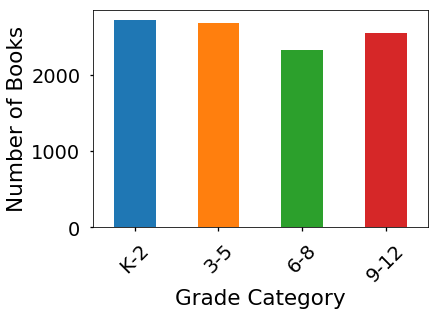

In [11]:
import seaborn as sns
sns.set_context("talk", font_scale=1.5)
ax = df.groupby(['GradeCategory']).count()['TitleID'].plot.bar()
# Consider stratified splitting. Mention alternative of downsampling
# 'Preschool/\nPre-K',
ax.set_xticklabels(['K-2','3-5', '6-8', '9-12'], rotation=45)
ax.set_xlabel('Grade Category')
ax.set_ylabel('Number of Books')

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["lemmatized_tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["lemmatized_tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

/anaconda3/envs/insight/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


345608 words total, with a vocabulary size of 20615
Max sentence length is 99


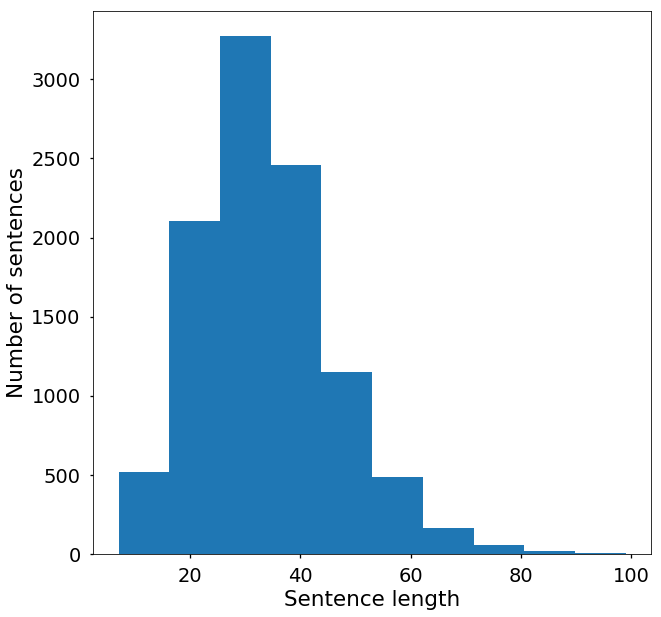

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

### First, let's try a Bag of Words Counts approach

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df["standarized_annotation"].tolist()
list_labels = df["GradeCategory"].tolist()

counts, count_vectorizer = cv(list_corpus)

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(counts, list_labels, test_size=0.2, 
                                                                                random_state=40)

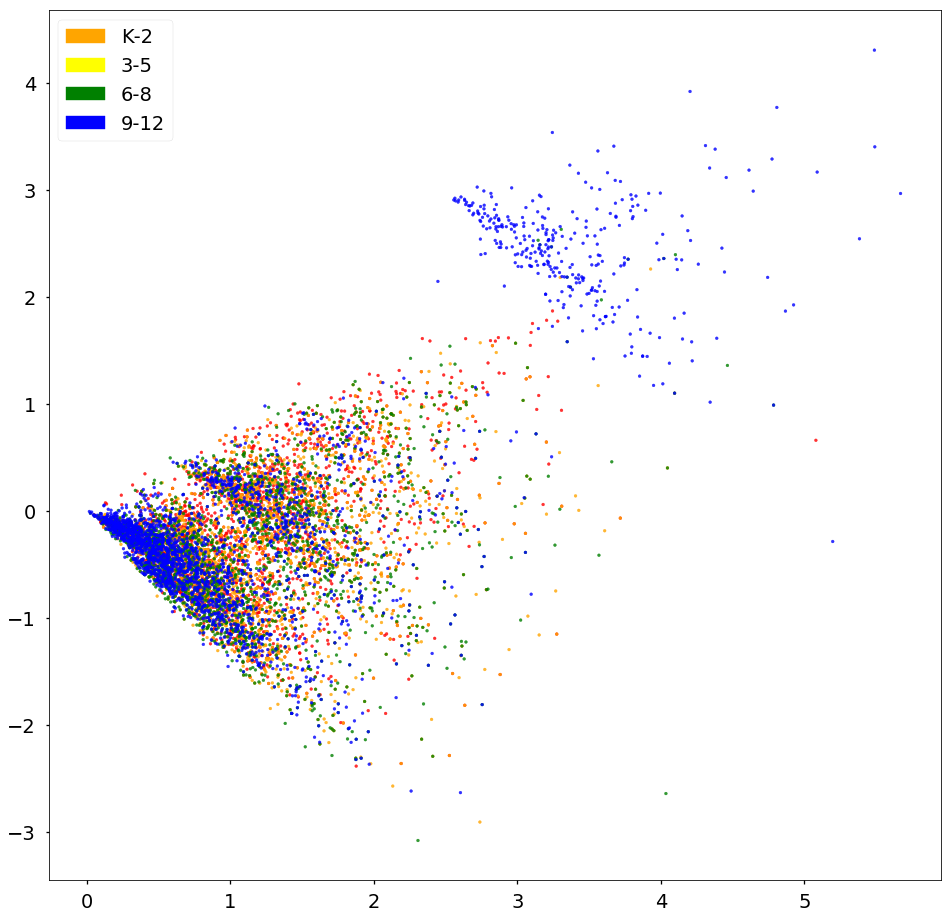

In [16]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red', 'orange', 'yellow', 'green', 'blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='K-2')
            yellow_patch = mpatches.Patch(color='yellow', label='3-5')
            green_patch = mpatches.Patch(color='green', label='6-8')
            blue_patch = mpatches.Patch(color='blue', label='9-12')
            plt.legend(handles=[orange_patch, yellow_patch, green_patch, blue_patch])


fig = plt.figure(figsize=(16, 16))          
plot_LSA(counts, list_labels)
plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train_counts)

y_predicted_counts = clf.predict(X_test_counts)

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test_counts, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.436, precision = 0.440, recall = 0.436, f1 = 0.438


In [34]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

Normalized confusion matrix


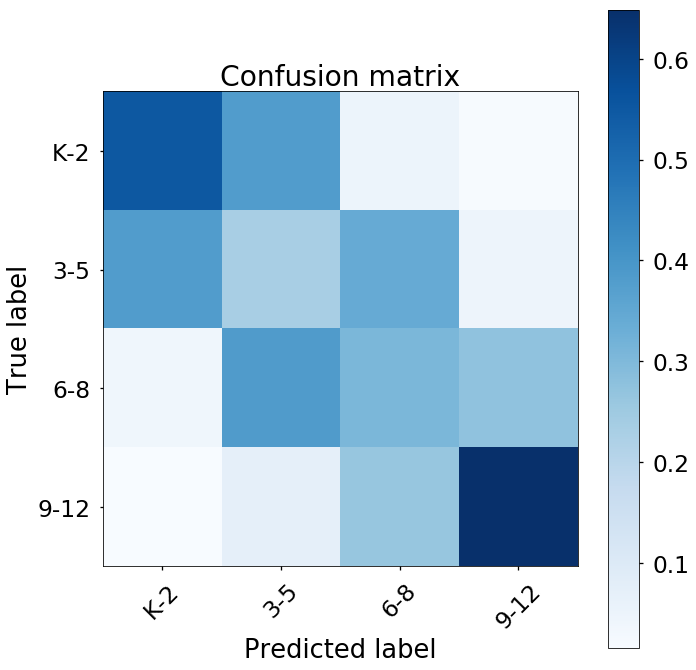

[[289 199  26  10]
 [204 124 182  25]
 [ 18 181 145 129]
 [  8  37 137 336]]


In [43]:
cm = confusion_matrix(y_test_counts, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['K-2','3-5', '6-8', '9-12'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

In [35]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottoms':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

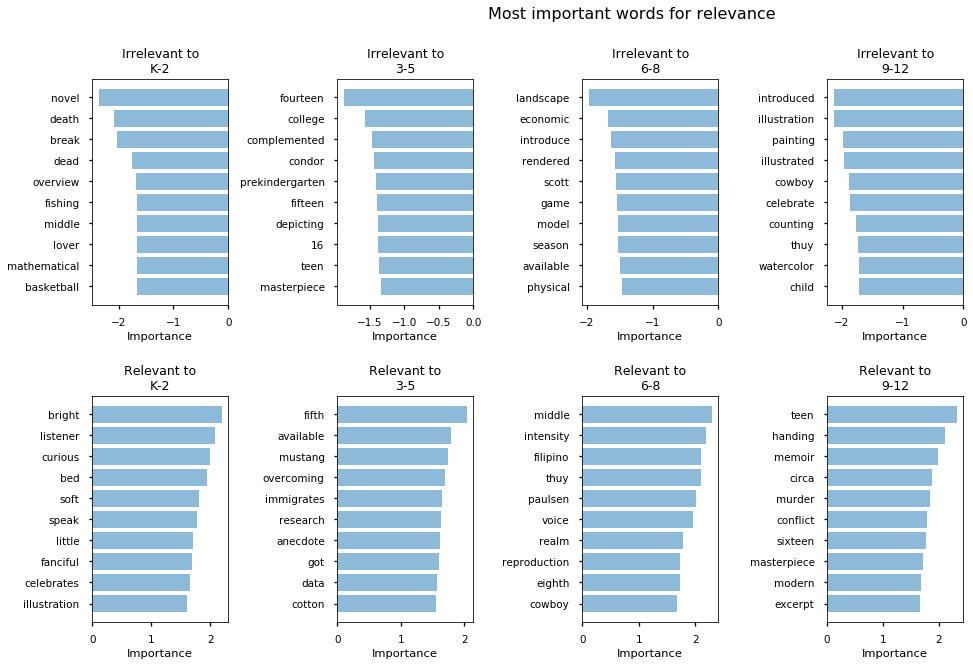

In [36]:
def plot_important_words(importance, name, keys=('bottoms', 'tops',)):
    fig = plt.figure(figsize=(20, 10))
    grade_categories = ('K-2','3-5', '6-8', '9-12')
    for idx, grade_category in enumerate(grade_categories):
        
        top_scores = [a[0] for a in importance[idx][keys[1]]]
        top_words = [a[1] for a in importance[idx][keys[1]]]
        bottom_scores = [a[0] for a in importance[idx][keys[0]]]
        bottom_words = [a[1] for a in importance[idx][keys[0]]]
        
        y_pos = np.arange(len(top_words))
        
        plt.subplot(2, 5, 1 + idx)
        plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
        plt.title('Irrelevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, bottom_words)
        plt.suptitle('Key words', fontsize=16)
        plt.xlabel('Importance')

        plt.subplot(2, 5, 6 + idx)
        plt.barh(y_pos,top_scores, align='center', alpha=0.5)
        plt.title('Relevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, top_words)
        plt.suptitle(name, fontsize=16)
        plt.xlabel('Importance')
    
    plt.subplots_adjust(wspace=0.8, hspace=0.4)
    plt.show()
    
sns.set_context("talk", font_scale=0.8)
plot_important_words(importance, "Most important words for relevance")
sns.set_context("talk", font_scale=1.5)

### TFIDF Bag of Words approach

In [115]:
# Max and min thresholds for tfidf. Maybe remove words that are only specific to a single book
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

tfidfs, tfidf_vectorizer = tfidf(list_corpus)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidfs, list_labels, test_size=0.2, 
                                                                            random_state=40)

In [116]:
import pickle
pickle_output = open("tfidf_vectorizer.pickle","wb")
pickle.dump(tfidf_vectorizer, pickle_output, pickle.HIGHEST_PROTOCOL)
pickle_output.close()

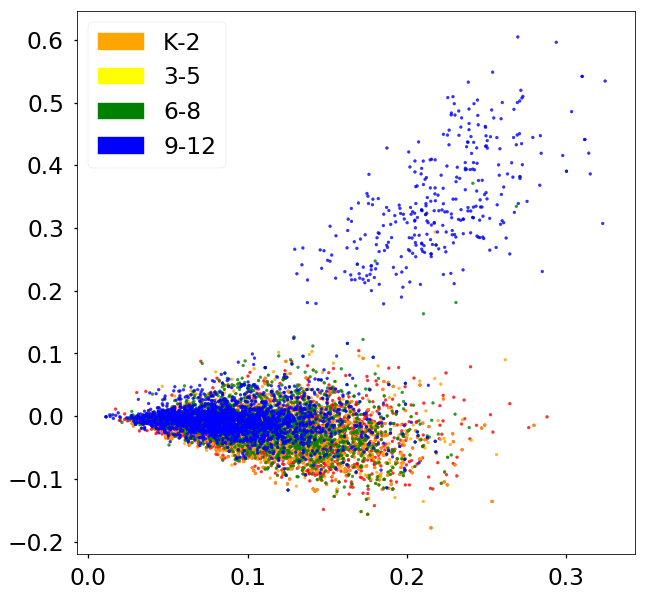

In [117]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(tfidfs, list_labels)
plt.show()

In [121]:
clf_tfidf = LogisticRegression(C=0.3341, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [122]:
import pickle
pickle_output = open("clf_tfidf.pickle","wb")
pickle.dump(clf_tfidf, pickle_output, pickle.HIGHEST_PROTOCOL)
pickle_output.close()

In [123]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test_tfidf, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.532, precision = 0.519, recall = 0.532, f1 = 0.523


Normalized confusion matrix


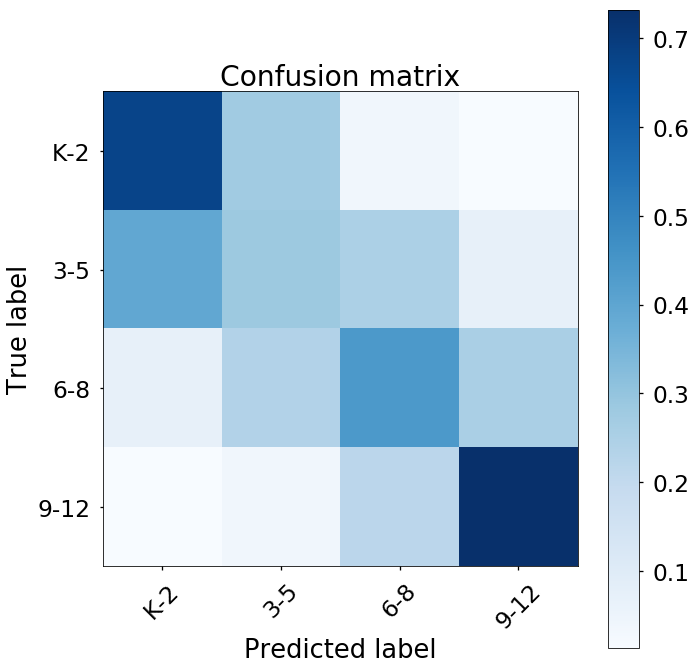

TFIDF confusion matrix
[[353 144  19   8]
 [211 152 134  38]
 [ 33 112 207 121]
 [  7  19 113 379]]
BoW confusion matrix
[[289 199  26  10]
 [204 124 182  25]
 [ 18 181 145 129]
 [  8  37 137 336]]


In [133]:
cm2 = confusion_matrix(y_test_tfidf, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
# 'Preschool/\nPre-K',
grade_categories = ('K-2','3-5', '6-8', '9-12')
sns.set_context("talk", font_scale=1.8)
plot = plot_confusion_matrix(cm2, classes=grade_categories, normalize=True, title='Confusion matrix')
plot.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

[[0.67366412 0.27480916 0.03625954 0.01526718]
 [0.39439252 0.28411215 0.25046729 0.07102804]
 [0.06976744 0.23678647 0.43763214 0.25581395]
 [0.01351351 0.03667954 0.21814672 0.73166023]]
Normalized confusion matrix


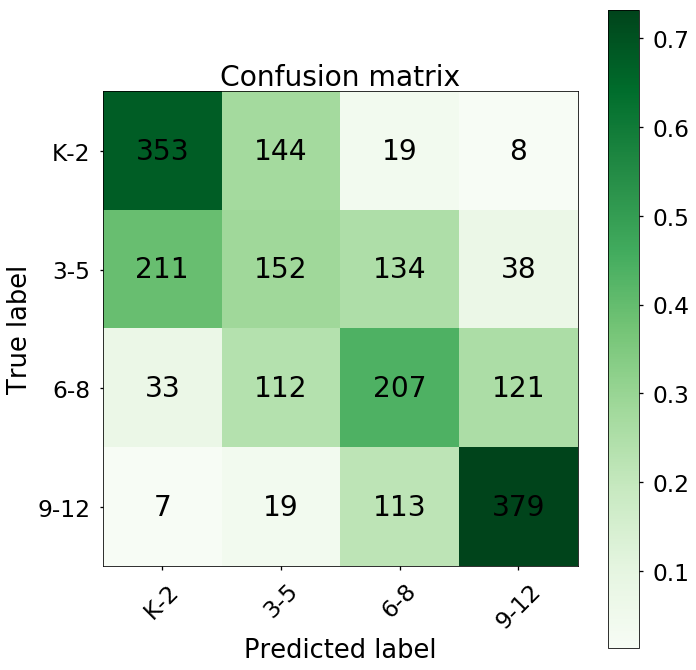

In [158]:
def plot_confusion_matrix_with_labels(cm, classes,
                                      normalize=False,
                                      title='Confusion matrix',
                                      cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
for (j,i),label in np.ndenumerate(cm2):
    ax.text(i,j,label,ha='center',va='center')
sns.set_context("talk", font_scale=1.8)
plot = plot_confusion_matrix_with_labels(cm2, classes=grade_categories, normalize=True, cmap=plt.cm.Greens)
plot.show()

In [159]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

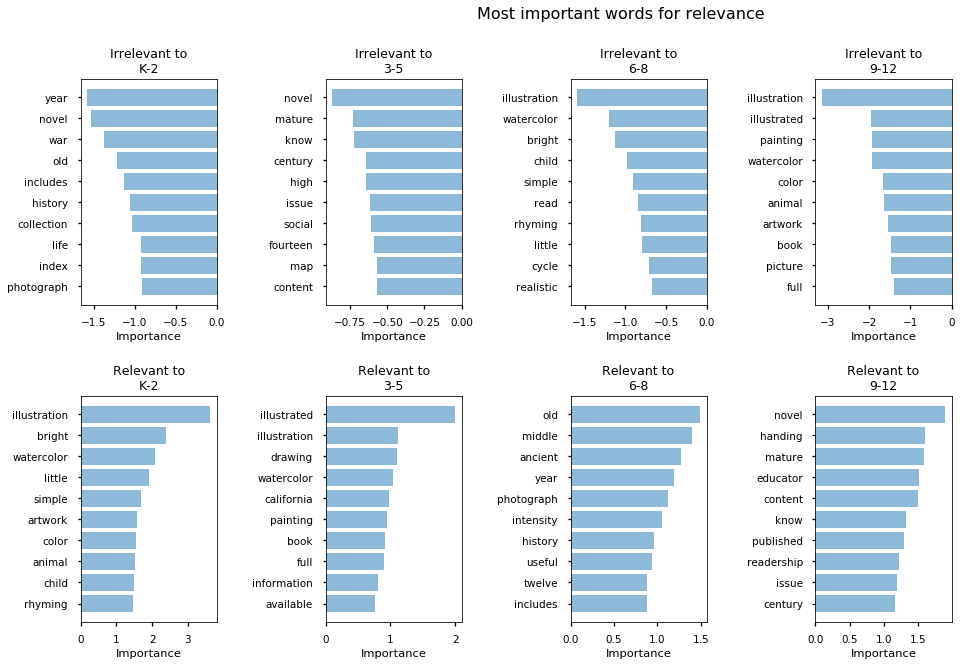

In [160]:
sns.set_context("talk", font_scale=0.8)
plot_important_words(importance_tfidf, "Most important words for relevance")
sns.set_context("talk", font_scale=1.5)

In [127]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
c = make_pipeline(tfidf_vectorizer, clf_tfidf)
grade_categories = ('K-2','3-5', '6-8', '9-12')
explainer = LimeTextExplainer(class_names=grade_categories)
exp = explainer.explain_instance(list_corpus[2], c.predict_proba, num_features=6, labels=[0, 1, 2, 3])
exp.show_in_notebook(text=True)

/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [128]:
import pickle
pickle_output = open("clf_tfidf.pickle","wb")
pickle.dump(clf_tfidf, pickle_output, pickle.HIGHEST_PROTOCOL)
pickle_output.close()

In [94]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

list_labels = df["GradeCategory"].tolist()
y = label_binarize(list_labels, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

tfidfs, tfidf_vectorizer = tfidf(list_corpus)

X_train, X_test, y_train, y_test = train_test_split(tfidfs, y, test_size=0.5, random_state=40, stratify=list_labels)

ovr_clf_tfidf = OneVsRestClassifier(LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                                                       multi_class='multinomial', n_jobs=-1, random_state=40))

y_score = ovr_clf_tfidf.fit(X_train, y_train).decision_function(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

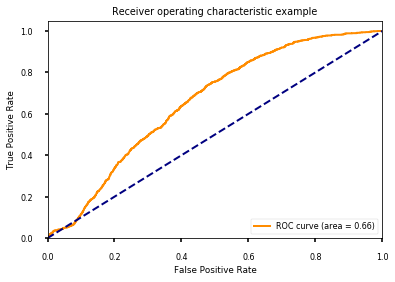

In [98]:
plt.figure()
lw = 2
category = 2
plt.plot(fpr[category], tpr[category], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[category])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

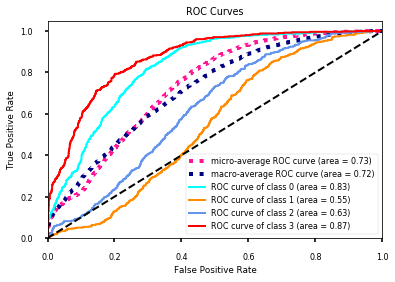

In [56]:
from scipy import interp
from itertools import cycle

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

sns.set_context("poster", font_scale=0.5)
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

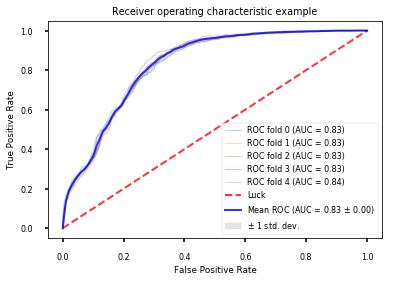

In [99]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True)

list_labels = df["GradeCategory"].tolist()
y = label_binarize(list_labels, classes=[0, 1, 2, 3])

tfidfs, tfidf_vectorizer = tfidf(list_corpus)
n_samples, n_features = tfidfs.shape

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(tfidfs, list_labels):
    ovr_clf_tfidf = OneVsRestClassifier(LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                                                       multi_class='multinomial', n_jobs=-1, random_state=40))
    y_score = ovr_clf_tfidf.fit(tfidfs[train], y[train]).decision_function(tfidfs[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test][:, 0], y_score[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Let's try word2vec

In [79]:
from gensim.models import Word2Vec
from nltk.corpus import brown
b = Word2Vec(brown.sents())

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
grade_categories = ('Preschool/Pre-K','K-2','3-5', '6-8', '9-12')
plot = plot_confusion_matrix(cm_w2v, classes=grade_categories, normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
res = []
for idy, row in enumerate(cm2):
    for idx, col in enumerate(row):
        res.append({'x': idx, 'y': idy, 'color': 'rbg(0, 0, {})'.format(col * 255 / 321)})
res

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [ ]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6, labels=[0, 1, 2, 3, 4])
    return exp

def visualize_one_exp(features, labels, index, class_names = ('Preschool/Pre-K','K-2','3-5', '6-8', '9-12',)):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
type(X_test_data[63])

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 63)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 60)

In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors': detractors,
            'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Preschool/Pre-K',
    1: 'K-2',
    2: '3-5',
    3: '6-8',
    4: '9-12',
}
sorted_contributions = get_statistical_explanation(X_test_data, 5, word2vec_pipeline, label_to_text)

In [ ]:
def plot_important_words_w2v(top_scores, top_words, bottom_scores, bottom_words, name, grade_category):
    y_pos = np.arange(len(top_words))

    fig = plt.figure(figsize=(10, 10))          
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant to\n{}'.format(grade_category))
    plt.yticks(y_pos, bottom_words)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance')
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Relevant to\n{}'.format(grade_category))
    plt.yticks(y_pos, top_words)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance')
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

grade_category = '9-12'
top_words = sorted_contributions[grade_category]['supporters'][:10].index.tolist()
top_scores = sorted_contributions[grade_category]['supporters'][:10].tolist()
bottom_words = sorted_contributions[grade_category]['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions[grade_category]['detractors'][:10].tolist()

plot_important_words_w2v(top_scores,
                         top_words,
                         bottom_scores,
                         bottom_words,
                         "Most important words for relevance",
                         grade_category=grade_category)